In [3]:
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
DATA_PATH = "synthetic_pub_beer_sales.csv"  # change if needed

df = pd.read_csv(DATA_PATH, parse_dates=["Date"])
df = df.sort_values(["Beer", "Date"]).reset_index(drop=True)

display(df.head())
print("Rows:", len(df), " | Beers:", df["Beer"].nunique(), " | Date range:", df["Date"].min().date(), "→", df["Date"].max().date())

,Date,Beer,DayOfWeek,UnitsSold,IsWeekend,HolidayEffect,PromoLevel
0,2021-01-01,Ale,4,19,0,0,0
1,2021-01-02,Ale,5,32,1,0,0
2,2021-01-03,Ale,6,31,1,0,0
3,2021-01-04,Ale,0,29,0,0,0
4,2021-01-05,Ale,1,38,0,0,0


Rows: 5475  | Beers: 5  | Date range: 2021-01-01 → 2023-12-31


create lagged 7 day usage

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Beer and Date (CRITICAL for rolling)
df = df.sort_values(['Beer', 'Date'])

# Create 7-day future usage target
df['target_7d_usage'] = (
    df
    .groupby('Beer')['UnitsSold']
    .transform(lambda x: x.rolling(window=7).sum().shift(-7))
)

# Drop rows with NaNs created by rolling + shifting
df = df.dropna(subset=['target_7d_usage']).reset_index(drop=True)

# Sanity check
df[['Beer', 'Date', 'UnitsSold', 'target_7d_usage']].head(10)

,Beer,Date,UnitsSold,target_7d_usage
0,Ale,2021-01-01,19,190.0
1,Ale,2021-01-02,32,191.0
2,Ale,2021-01-03,31,187.0
3,Ale,2021-01-04,29,189.0
4,Ale,2021-01-05,38,177.0
5,Ale,2021-01-06,17,192.0
6,Ale,2021-01-07,23,192.0
7,Ale,2021-01-08,20,204.0
8,Ale,2021-01-09,33,210.0
9,Ale,2021-01-10,27,216.0


check 7 day usage is correct

In [6]:
beer = 'Ale'

df_check = df[df['Beer'] == beer].reset_index(drop=True)

# Pick a row to inspect
i = 0

print(df_check.loc[i, ['Date', 'UnitsSold', 'target_7d_usage']])

print("\nNext 7 days sales:")
print(df_check.loc[i+1:i+7, ['Date', 'UnitsSold']])

print("\nManual sum:")
print(df_check.loc[i+1:i+7, 'UnitsSold'].sum())

check = (
    df
    .groupby('Beer')
    .apply(
        lambda g: (
            g['target_7d_usage']
            - g['UnitsSold'].shift(-1).rolling(7).sum().shift(-6)
        ).dropna()
    )
)

print(f"Max absolute error: {check.abs().max()}")


Date               2021-01-01 00:00:00
UnitsSold                           19
target_7d_usage                  190.0
Name: 0, dtype: object

Next 7 days sales:
        Date  UnitsSold
1 2021-01-02         32
2 2021-01-03         31
3 2021-01-04         29
4 2021-01-05         38
5 2021-01-06         17
6 2021-01-07         23
7 2021-01-08         20

Manual sum:
190
Max absolute error: 0.0


Create Basline model (7 day lagged usage) and evaluate performance

Baseline MAE:  10.30 units
Baseline RMSE: 13.30 units


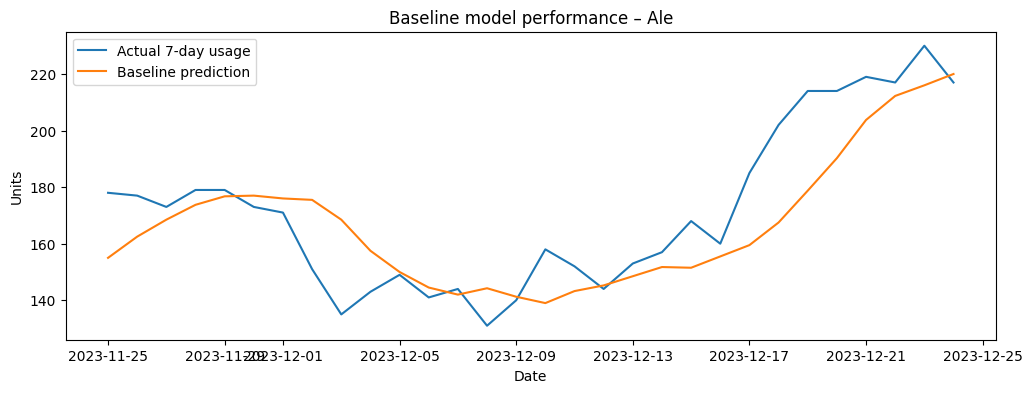

In [7]:
df['usage_7d_past'] = (
    df
    .groupby('Beer')['target_7d_usage']
    .shift(1)
)

df['baseline_pred_7d'] = (
    df
    .groupby('Beer')['usage_7d_past']
    .transform(lambda x: x.rolling(window=4).mean())
)


df_baseline = df.dropna(
    subset=['baseline_pred_7d', 'target_7d_usage']
).reset_index(drop=True)

y_true = df_baseline['target_7d_usage']
y_pred_baseline = df_baseline['baseline_pred_7d']

beer = 'Ale'
df_baseline[df_baseline['Beer'] == beer][
    ['Date', 'baseline_pred_7d', 'target_7d_usage']
].head(10)


# True values and baseline predictions
y_true = df_baseline['target_7d_usage']
y_pred = df_baseline['baseline_pred_7d']

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Baseline MAE:  {mae:.2f} units")
print(f"Baseline RMSE: {rmse:.2f} units")

import matplotlib.pyplot as plt

beer = 'Ale'
df_plot = df_baseline[df_baseline['Beer'] == beer].iloc[-30:]

plt.figure(figsize=(12,4))
plt.plot(df_plot['Date'], df_plot['target_7d_usage'], label='Actual 7-day usage')
plt.plot(df_plot['Date'], df_plot['baseline_pred_7d'], label='Baseline prediction')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Units')
plt.title(f'Baseline model performance – {beer}')
plt.show()


In [8]:
# ------------------------------------------------------------
# Feature engineering
# ------------------------------------------------------------

# Lagged weekly usage (t-2)
df['usage_7d_t-2'] = df.groupby('Beer')['usage_7d_past'].shift(1)

# Rolling statistics based on past weekly usage
df['usage_7d_mean_3w'] = (
    df.groupby('Beer')['usage_7d_past']
      .transform(lambda x: x.rolling(window=3).mean())
)

df['usage_7d_std_3w'] = (
    df.groupby('Beer')['usage_7d_past']
      .transform(lambda x: x.rolling(window=3).std())
)

# Short-term absolute trend
df['usage_7d_trend'] = df['usage_7d_past'] - df['usage_7d_t-2']

# Percentage change (momentum feature)
df['usage_7d_pct_change'] = (
    (df['usage_7d_past'] - df['usage_7d_t-2'])
    / df['usage_7d_t-2']
)

# Clean infinities from division
df['usage_7d_pct_change'] = df['usage_7d_pct_change'].replace(
    [np.inf, -np.inf], np.nan
)

# Calendar features
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)
df['month'] = df['Date'].dt.month

le = LabelEncoder()
df['beer_id'] = le.fit_transform(df['Beer'])

feature_cols = [
    'usage_7d_past',        # t-1 weekly usage
    'usage_7d_t-2',         # t-2 weekly usage
    'usage_7d_mean_3w',     # recent average
    'usage_7d_std_3w',      # recent variability
    'usage_7d_trend',       # absolute trend
    'usage_7d_pct_change', # momentum
    'week_of_year',
    'month',
    'DayOfWeek',
    'IsWeekend',
    'HolidayEffect',
    'PromoLevel',
    'beer_id'
]

df_model = df.dropna(
    subset=feature_cols + ['target_7d_usage', 'baseline_pred_7d']
).reset_index(drop=True)

print("Model-ready rows:", len(df_model))
display(df_model.head())

Model-ready rows: 5420


,Date,Beer,DayOfWeek,UnitsSold,IsWeekend,HolidayEffect,PromoLevel,target_7d_usage,usage_7d_past,baseline_pred_7d,usage_7d_t-2,usage_7d_mean_3w,usage_7d_std_3w,usage_7d_trend,usage_7d_pct_change,week_of_year,month,beer_id
0,2021-01-05,Ale,1,38,0,0,0,177.0,189.0,189.25,187.0,189.000000,2.000000,2.0,0.010695,1,1,0
1,2021-01-06,Ale,2,17,0,0,0,192.0,177.0,186.00,189.0,184.333333,6.429101,-12.0,-0.063492,1,1,0
2,2021-01-07,Ale,3,23,0,0,0,192.0,192.0,186.25,177.0,186.000000,7.937254,15.0,0.084746,1,1,0
3,2021-01-08,Ale,4,20,0,0,0,204.0,192.0,187.50,192.0,187.000000,8.660254,0.0,0.000000,1,1,0
4,2021-01-09,Ale,5,33,1,0,0,210.0,204.0,191.25,192.0,196.000000,6.928203,12.0,0.062500,1,1,0


In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use same df_model, features, split as before

X = df_model[feature_cols]
y = df_model['target_7d_usage']

def time_split_per_beer(df, feature_cols, target_col, test_frac=0.2):
    train_idx = []
    test_idx = []

    for beer, g in df.groupby('Beer'):
        g = g.sort_values('Date')
        split = int(len(g) * (1 - test_frac))
        train_idx.extend(g.index[:split])
        test_idx.extend(g.index[split:])

    X_train = df.loc[train_idx, feature_cols]
    X_test  = df.loc[test_idx, feature_cols]

    y_train = df.loc[train_idx, target_col]
    y_test  = df.loc[test_idx, target_col]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = time_split_per_beer(
    df_model,
    feature_cols,
    target_col='target_7d_usage',
    test_frac=0.2
)


y_baseline_test = df_model.loc[X_test.index, 'baseline_pred_7d']

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import numpy as np

alphas = np.logspace(-3, 3, 20)
maes = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_test)
    maes.append(mean_absolute_error(y_test, preds))

best_alpha = alphas[np.argmin(maes)]

print(f"Best alpha: {best_alpha:.4f}")
print(f"Best MAE:   {min(maes):.2f}")

# Train Ridge regression
ridge = Ridge(alpha=best_alpha)   # alpha controls regularisation
ridge.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge.predict(X_test)

# Evaluation
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print("=== Baseline ===")
print(f"MAE:  {mean_absolute_error(y_test, y_baseline_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_baseline_test)):.2f}")

print("\n=== Ridge Regression ===")
print(f"MAE:  {mae_ridge:.2f}")
print(f"RMSE: {rmse_ridge:.2f}")

# --- Percentage accuracy (slide-friendly) ---
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

baseline_mape = safe_mape(y_test.values, y_baseline_test.values)
ridge_mape    = safe_mape(y_test.values, y_pred_ridge)

baseline_accuracy_pct = 100.0 - baseline_mape
ridge_accuracy_pct    = 100.0 - ridge_mape

print("\n=== Percentage Accuracy (Slide-friendly) ===")
print(f"Baseline MAPE: {baseline_mape:.2f}%  → Accuracy: {baseline_accuracy_pct:.2f}%")
print(f"Ridge   MAPE: {ridge_mape:.2f}%  → Accuracy: {ridge_accuracy_pct:.2f}%")



Best alpha: 12.7427
Best MAE:   6.70
=== Baseline ===
MAE:  10.30
RMSE: 13.45

=== Ridge Regression ===
MAE:  6.70
RMSE: 8.61

=== Percentage Accuracy (Slide-friendly) ===
Baseline MAPE: 5.11%  → Accuracy: 94.89%
Ridge   MAPE: 3.40%  → Accuracy: 96.60%


Plotting 217 points for beer: Ale


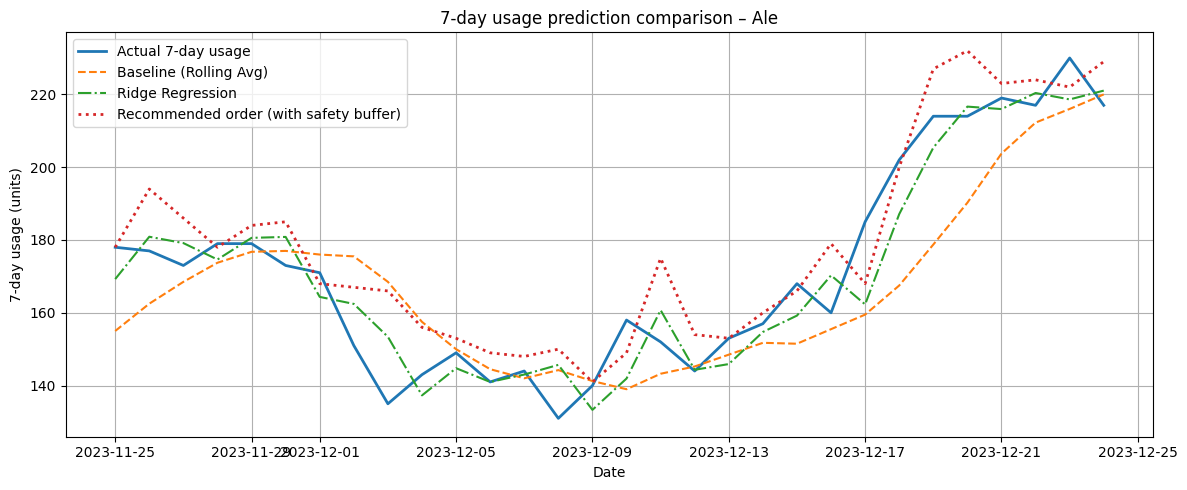

In [10]:


# ---- Choose a beer THAT EXISTS in the test set
beer = df_model.loc[y_test.index, 'Beer'].iloc[0]

# ---- Build a clean test dataframe
df_test = df_model.loc[y_test.index, [
    'Date', 'Beer', 'target_7d_usage'
]].copy()

df_test['baseline_pred'] = y_baseline_test.values
df_test['ridge_pred'] = y_pred_ridge

# ------------------------------------------------------------
# Add safety buffer to Ridge prediction (ORDERING DECISION)
# ------------------------------------------------------------

k = 1.0  # safety factor (use 1.0 or 1.65 for more conservative ordering)

df_test['order_recommendation'] = (
    df_test['ridge_pred']
    + k * df_model.loc[y_test.index, 'usage_7d_std_3w'].values
)

# Optional: round up to whole units
df_test['order_recommendation'] = np.ceil(df_test['order_recommendation'])

# ---- Filter to chosen beer
df_plot = df_test[df_test['Beer'] == beer].sort_values('Date')

print(f"Plotting {len(df_plot)} points for beer: {beer}")

# ---- Safety check
if len(df_plot) == 0:
    raise ValueError("No data to plot — beer not found in test set.")

# ---- Limit points for clarity
df_plot = df_plot.tail(30)

# ---- Plot
plt.figure(figsize=(12, 5))

plt.plot(df_plot['Date'], df_plot['target_7d_usage'],
         label='Actual 7-day usage', linewidth=2)

plt.plot(df_plot['Date'], df_plot['baseline_pred'],
         label='Baseline (Rolling Avg)', linestyle='--')

plt.plot(df_plot['Date'], df_plot['ridge_pred'],
         label='Ridge Regression', linestyle='-.')

plt.plot(
    df_plot['Date'],
    df_plot['order_recommendation'],
    label='Recommended order (with safety buffer)',
    linestyle=':',
    linewidth=2
)
plt.xlabel('Date')
plt.ylabel('7-day usage (units)')
plt.title(f'7-day usage prediction comparison – {beer}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()